In [1]:
! pip install kagglehub


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import kagglehub
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.utils import resample
import numpy as np

/Users/victoriayuzova/Data-Science-Projects/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# Download latest version
path = kagglehub.dataset_download("amirmotefaker/ab-testing-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/victoriayuzova/.cache/kagglehub/datasets/amirmotefaker/ab-testing-dataset/versions/1


In [4]:
# Read the CSV files from the dataset directory (using semicolon separator)
control_df = pd.read_csv(f"{path}/control_group.csv", sep=';')

control_df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
test_df = pd.read_csv(f"{path}/test_group.csv", sep=';')

test_df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [6]:
df = pd.concat([control_df, test_df])
df.head()
df.tail()
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        60 non-null     object 
 1   Date                 60 non-null     object 
 2   Spend [USD]          60 non-null     int64  
 3   # of Impressions     59 non-null     float64
 4   Reach                59 non-null     float64
 5   # of Website Clicks  59 non-null     float64
 6   # of Searches        59 non-null     float64
 7   # of View Content    59 non-null     float64
 8   # of Add to Cart     59 non-null     float64
 9   # of Purchase        59 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 5.2+ KB


Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64

In [7]:
# remove incomplete records
# in real business setting we should figure out why records are incomplete but now we will just imagine they are not important

df.dropna(inplace=True)
df.isnull().sum()

# check for duplicates
df.duplicated().sum()

# remove duplicates
df.drop_duplicates(inplace=True)


In [8]:
# Rename the 'Campaign Name' column to 'group'
df.rename(columns={'Campaign Name': 'group'}, inplace=True)
df['group'].value_counts()


group
Test Campaign       30
Control Campaign    29
Name: count, dtype: int64

Hypothesis: New Design of the Webpage ('Test') improves customer spend and number of purchases

In [9]:
df.groupby('group')['Spend [USD]'].mean()

group
Control Campaign    2304.068966
Test Campaign       2563.066667
Name: Spend [USD], dtype: float64

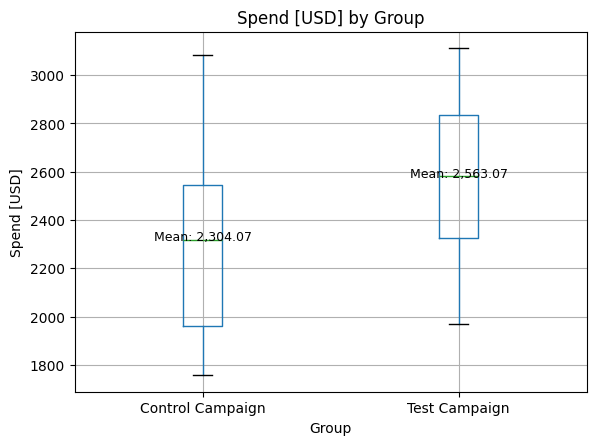

In [14]:
ax = df.boxplot(column='Spend [USD]', by='group')
plt.suptitle('')  # Remove the default "boxplot grouped by group" title
ax.set_title('Spend [USD] by Group')
ax.set_xlabel('Group')
ax.set_ylabel('Spend [USD]')

# Add mean labels (simplified version)
means = df.groupby('group')['Spend [USD]'].mean()
for idx in range(len(means)):
    i = idx + 1  # Start from 1
    mean_val = means.iloc[idx]
    ax.text(i, mean_val, f'Mean: {mean_val:,.2f}', 
            ha='center', va='bottom', fontsize=9)

plt.show()


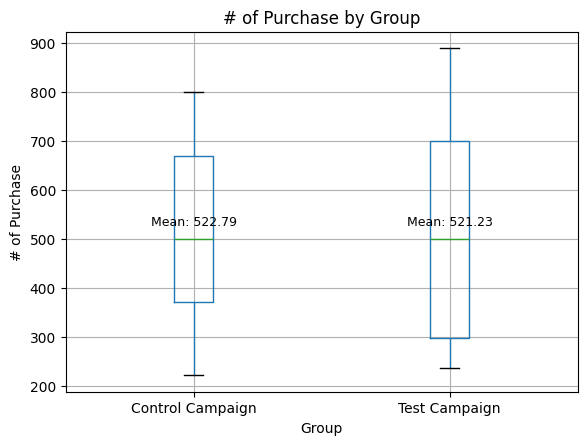

In [ ]:
ax = df.boxplot(column='# of Purchase', by='group')
plt.suptitle('')  # Remove the default "boxplot grouped by group" title
ax.set_title('# of Purchase by Group')
ax.set_xlabel('Group')
ax.set_ylabel('# of Purchase')

# Add mean labels (simplified version)
means = df.groupby('group')['# of Purchase'].mean()
for idx in range(len(means)):
    i = idx + 1  # Start from 1
    mean_val = means.iloc[idx]
    ax.text(i, mean_val, f'Mean: {mean_val:,.2f}', 
            ha='center', va='bottom', fontsize=9)

plt.show()


Bootstrapping: How Confident can we be about the results?

In [12]:
results = []
for i in range(1000):
    sample_control = resample(control_df['Spend [USD]'])
    sample_test = resample(test_df['Spend [USD]'])
    results.append(sample_test.mean() - sample_control.mean())

results = pd.Series(results)

control_mean = df[df['group']=='Control Campaign']['Spend [USD]'].mean()
test_mean = df[df['group']=='Test Campaign']['Spend [USD]'].mean()
original_diff = test_mean-control_mean

print('Bootstrap Statistics')
print(f'Original Mean Difference: {original_diff.round(2)}')
print(f'Bias: {(results.mean()- original_diff).round(2)}')
print(f'Std Error: {(results.std()).round(2)}')

Bootstrap Statistics
Original Mean Difference: 259.0
Bias: 17.11
Std Error: 93.35


In [ ]:
# For spend, mean difference could vary up to 93 USD due to random sampling
# Bias is much lower than standard error, so we can be confident about the results

In [15]:
results = []
for i in range(1000):
    sample_control = resample(control_df['# of Purchase'])
    sample_test = resample(test_df['# of Purchase'])
    results.append(sample_test.mean() - sample_control.mean())

results = pd.Series(results)

control_mean = df[df['group']=='Control Campaign']['# of Purchase'].mean()
test_mean = df[df['group']=='Test Campaign']['# of Purchase'].mean()
original_diff = test_mean-control_mean

print('Bootstrap Statistics')
print(f'Original Mean Difference: {original_diff.round(2)}')
print(f'Bias: {(results.mean()- original_diff).round(2)}')
print(f'Std Error: {(results.std()).round(2)}')

Bootstrap Statistics
Original Mean Difference: -1.56
Bias: -0.16
Std Error: 51.97


In [16]:
# For number of purchases, mean difference could vary up to 52.0 purchases due to random sampling (standard error )
# Bias is much lower than standard error, so we can be confident about the results

Is the difference statistically significant? Permutation test